# Project: Identify Customer Segments

In this project, unsupervised learning techniques are applied to identify segments of the _population_ that form the _core customer_ base for a mail-order sales company in Germany. These segments can later be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that is used has been provided by Bertelsmann Arvato Analytics.

### Data

There are four data files associated with this project:

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. 

This data is used to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import ast
!pip install missingno
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from workspace_utils import active_session

# magic word for producing visualizations in notebook
%matplotlib inline


In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [3]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [4]:
# population info
azdias.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. This file is used to make cleaning decisions and the demographics data is assessed in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data.

In [5]:
# load workspace_utils
!curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1554  100  1554    0     0   9370      0 --:--:-- --:--:-- --:--:-- 10025


In [6]:
import time
start_time = time.time()

# Identify missing or unknown data values and convert them to NaNs.
for i in range(len(feat_info)):

    missing_or_unknown_data = feat_info.iloc[i]['missing_or_unknown']
    missing_or_unknown_data = missing_or_unknown_data.strip('[]').split(',')
    missing_or_unknown_data = [int(value) if (value!='' and value!='X' and value!='XX') else value for value in missing_or_unknown_data]
   
    if missing_or_unknown_data != ['']:
        print(f'Missing or unknown data: {feat_info.iloc[i]["attribute"]} : {missing_or_unknown_data}')
        azdias = azdias.replace({feat_info.iloc[i]['attribute']:missing_or_unknown_data}, np.nan)

# save the new dataframe 
azdias.to_csv('azdias_find_nans.csv')
              
print("--- %s seconds ---" % (time.time() - start_time))

Missing or unknown data: AGER_TYP : [-1, 0]
Missing or unknown data: ALTERSKATEGORIE_GROB : [-1, 0, 9]
Missing or unknown data: ANREDE_KZ : [-1, 0]
Missing or unknown data: CJT_GESAMTTYP : [0]
Missing or unknown data: FINANZ_MINIMALIST : [-1]
Missing or unknown data: FINANZ_SPARER : [-1]
Missing or unknown data: FINANZ_VORSORGER : [-1]
Missing or unknown data: FINANZ_ANLEGER : [-1]
Missing or unknown data: FINANZ_UNAUFFAELLIGER : [-1]
Missing or unknown data: FINANZ_HAUSBAUER : [-1]
Missing or unknown data: FINANZTYP : [-1]
Missing or unknown data: GEBURTSJAHR : [0]
Missing or unknown data: HEALTH_TYP : [-1, 0]
Missing or unknown data: LP_LEBENSPHASE_FEIN : [0]
Missing or unknown data: LP_LEBENSPHASE_GROB : [0]
Missing or unknown data: LP_FAMILIE_FEIN : [0]
Missing or unknown data: LP_FAMILIE_GROB : [0]
Missing or unknown data: LP_STATUS_FEIN : [0]
Missing or unknown data: LP_STATUS_GROB : [0]
Missing or unknown data: NATIONALITAET_KZ : [-1, 0]
Missing or unknown data: PRAEGENDE_JUGEND

In [7]:
# Show missing values as %
ms_val_cols = (azdias.isna().sum()/azdias.shape[0]).sort_values(ascending=False)
ms_val_cols[ms_val_cols.values > 0.5]

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
dtype: float64

In [8]:
# Fill misisng values to nan
azdias.fillna(np.nan, inplace=True)

# All missing values
azdias.isna().sum().sum()


8373929

#### Step 1.1.2: Assess Missing Data in Each Column

- How much missing data is present in each column? 
- Are there any patterns in which columns have, or share, missing data?

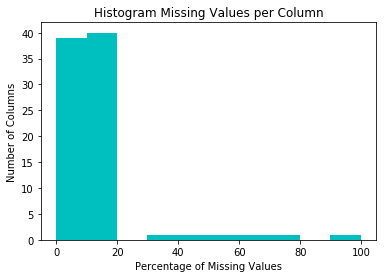

In [9]:
# Missing values per column
nulls = azdias.isna().sum()/azdias.shape[0]*100
plt.hist(nulls, color='c')
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.title('Histogram Missing Values per Column')
plt.show()

In [10]:
# Missing data in each column - show top columns 
azdias.isna().sum().sort_values(ascending=False).head(10)

TITEL_KZ          889061
AGER_TYP          685843
KK_KUNDENTYP      584612
KBA05_BAUMAX      476524
GEBURTSJAHR       392318
ALTER_HH          310267
REGIOTYP          158064
KKK               158064
W_KEIT_KIND_HH    147988
KBA05_ANTG4       133324
dtype: int64

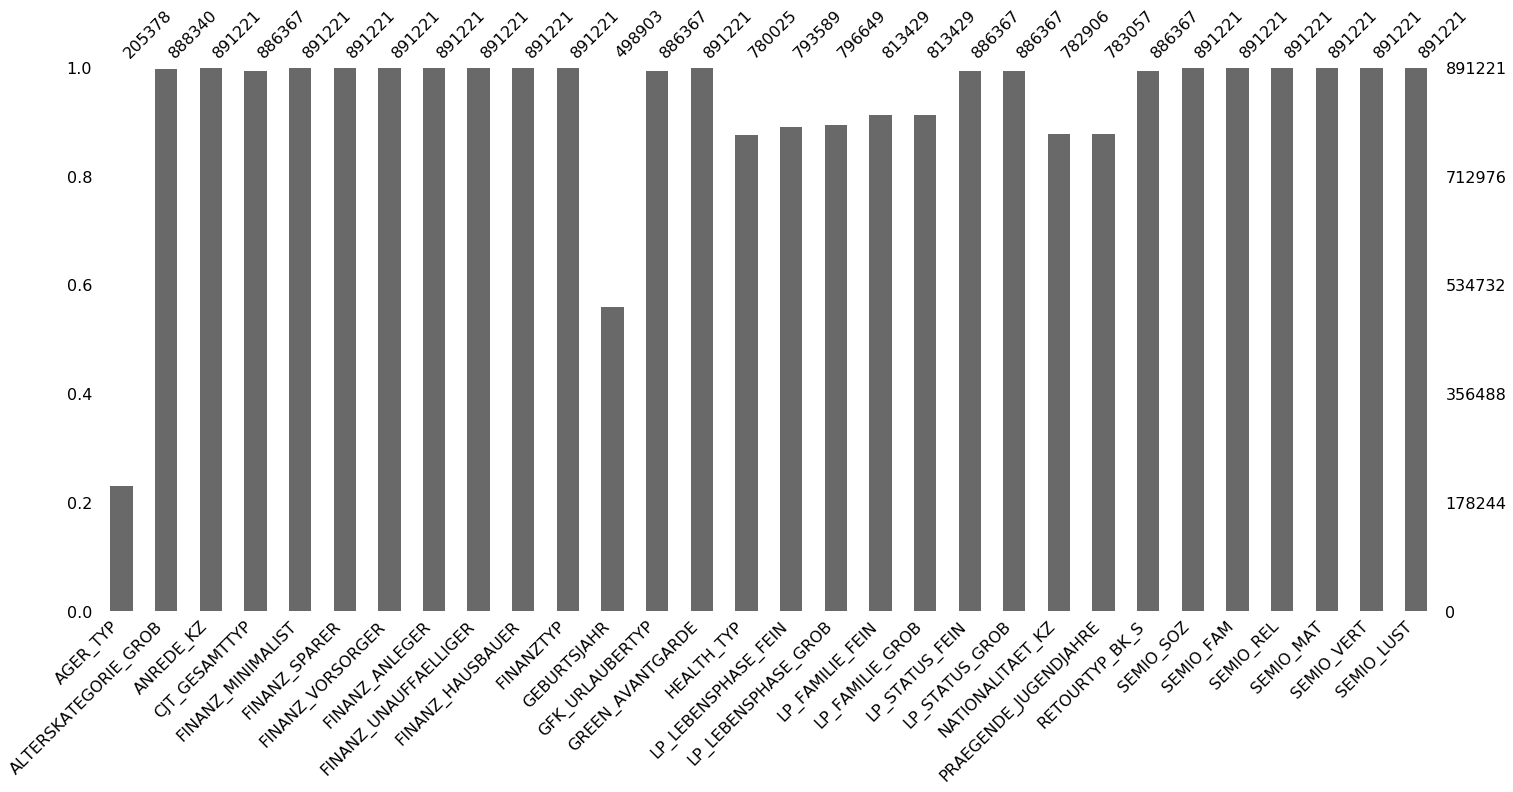

In [11]:
# Data in each column part 1
msno.bar(azdias.iloc[:,0:30]);

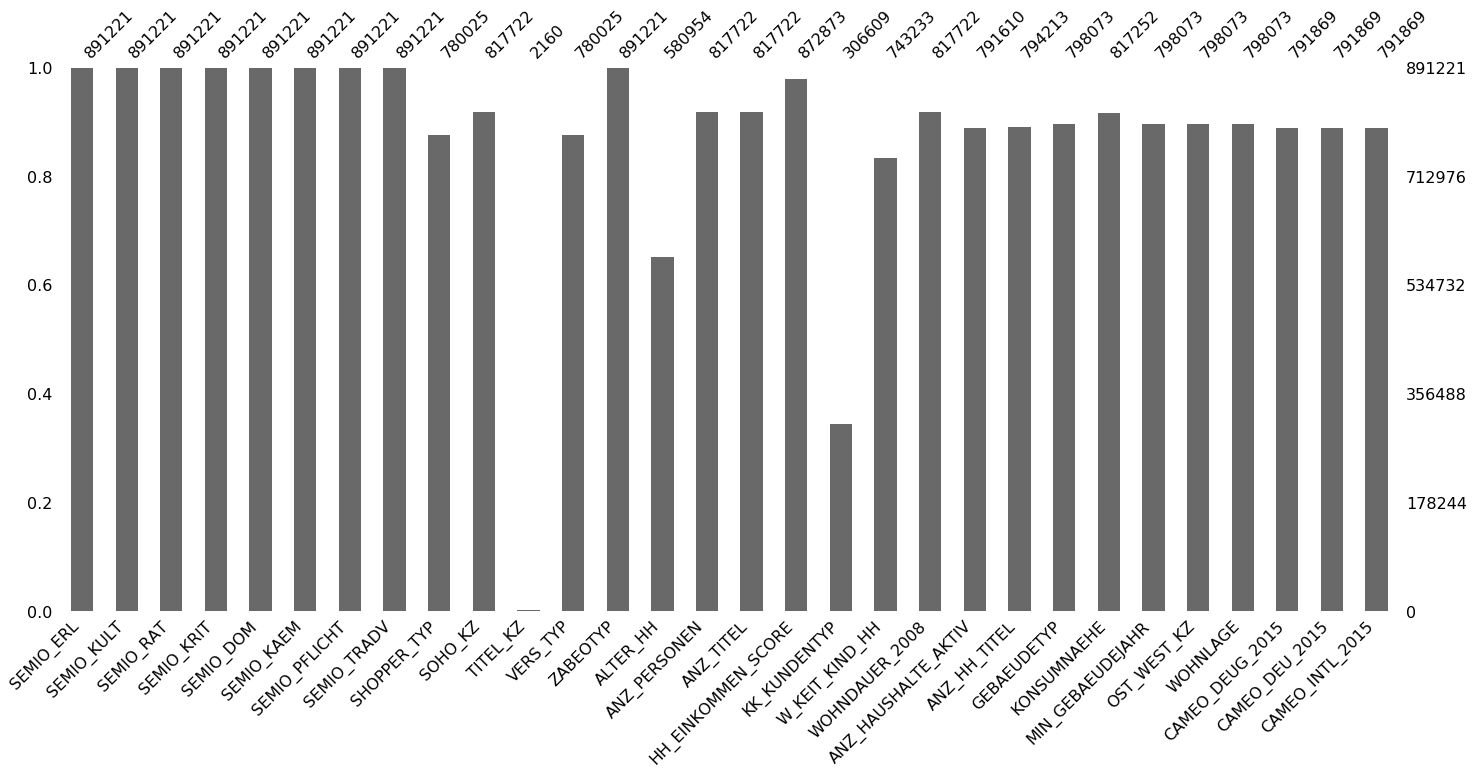

In [12]:
# Data in each column part 2
msno.bar(azdias.iloc[:,30:60]);

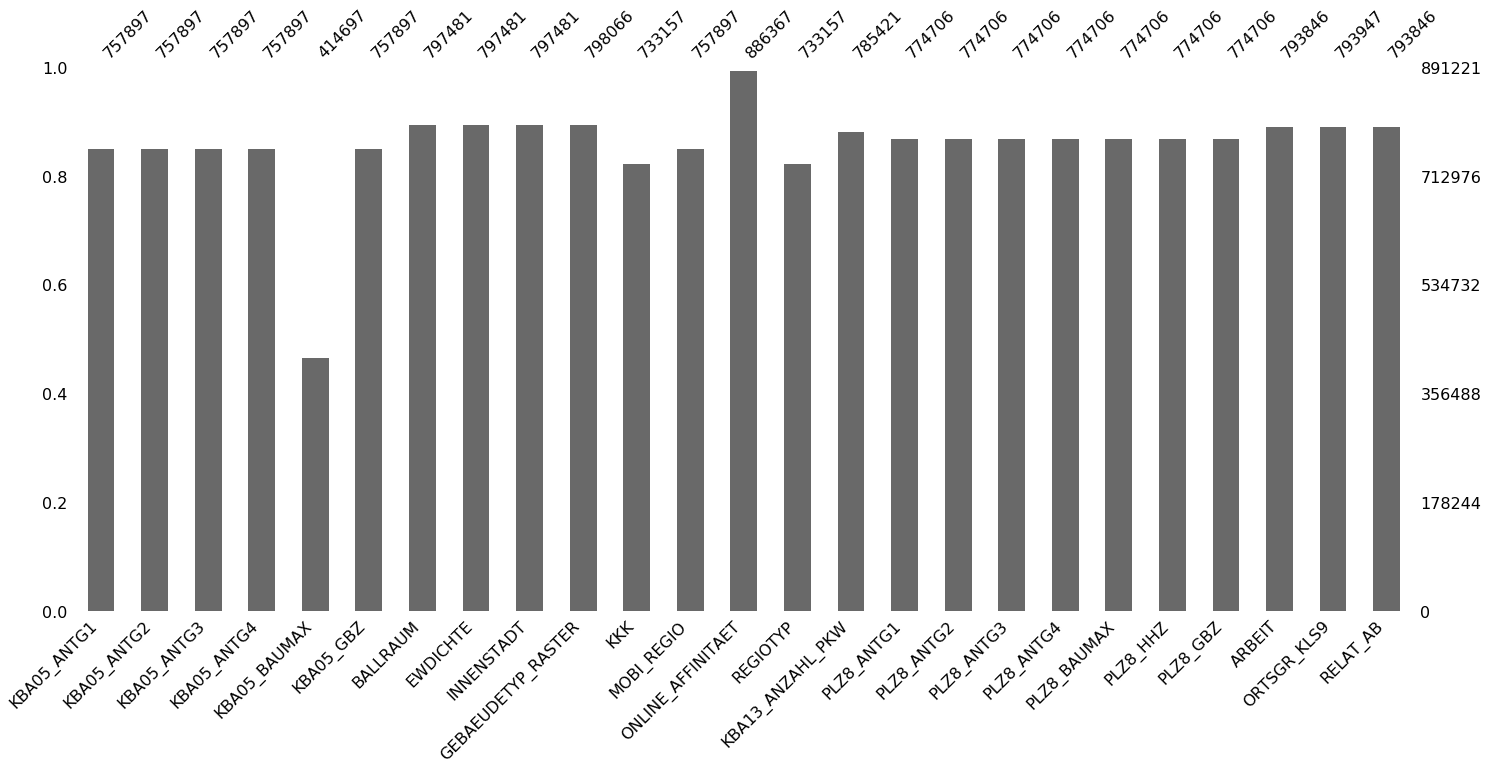

In [13]:
# Data in each column part 3
msno.bar(azdias.iloc[:,60:90]);


In [14]:
# Missing data filtering of column outliers
outlier_column_name = nulls[nulls.sort_values(ascending=False) > 50].index
outlier_column_name

Index(['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], dtype='object')

In [15]:
# Remove the outlier columns from the dataset
population = azdias.copy()
population.drop(outlier_column_name, axis=1, inplace=True)


#### Discussion 1.1.2: Assess Missing Data in Each Column
All columns, except for one, contains 20 % of missing values or less.
The outlier, KK_KUNDENTYP, was missing more than 60 % of the values and was removed from the dataset. 

#### Step 1.1.3: Assess Missing Data in Each Row

- How much data is missing in each row? 
- The data is divided into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.


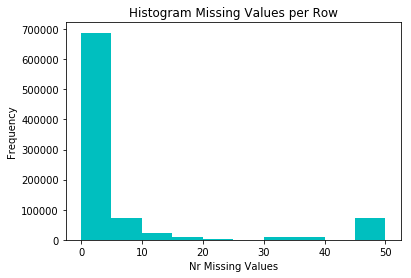

In [16]:
# How much data is missing in each row of the dataset?
plt.hist(population.isna().sum(axis=1).sort_values(ascending=False), color='c');
plt.title('Histogram Missing Values per Row');
plt.ylabel('Frequency');
plt.xlabel('Nr Missing Values');

In [17]:
# View the missing values
missing_values = population.isna().sum(axis=1).sort_values(ascending=False)
print(missing_values.head(10))

# Create a list of rows with too many missing values
limit = 25
msval_idxlist = list(missing_values[missing_values > limit].index)

732775    50
643174    50
554349    49
288539    49
716425    49
68140     49
288589    49
288588    49
288587    49
850248    49
dtype: int64


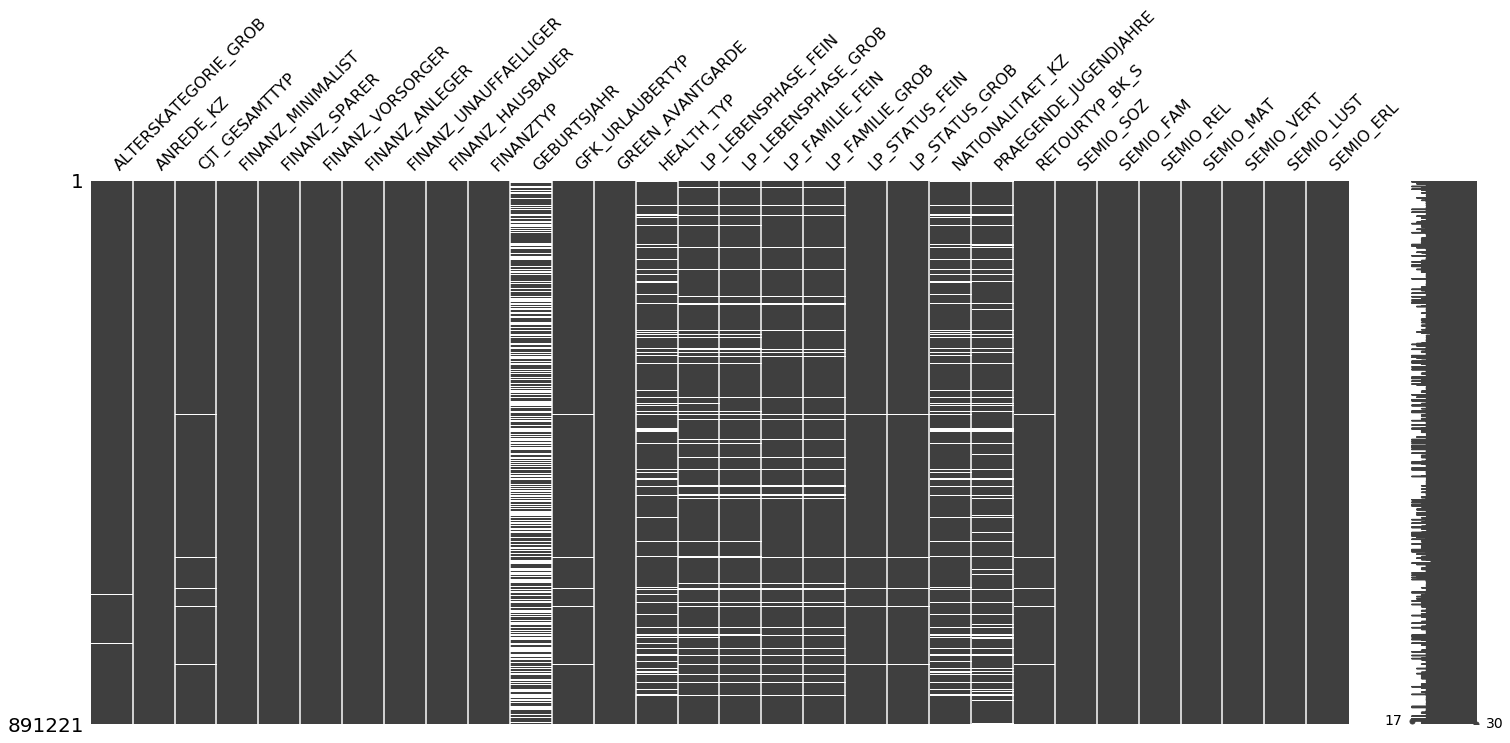

In [18]:
# View the missing values
msno.matrix(population.iloc[:,0:30]);


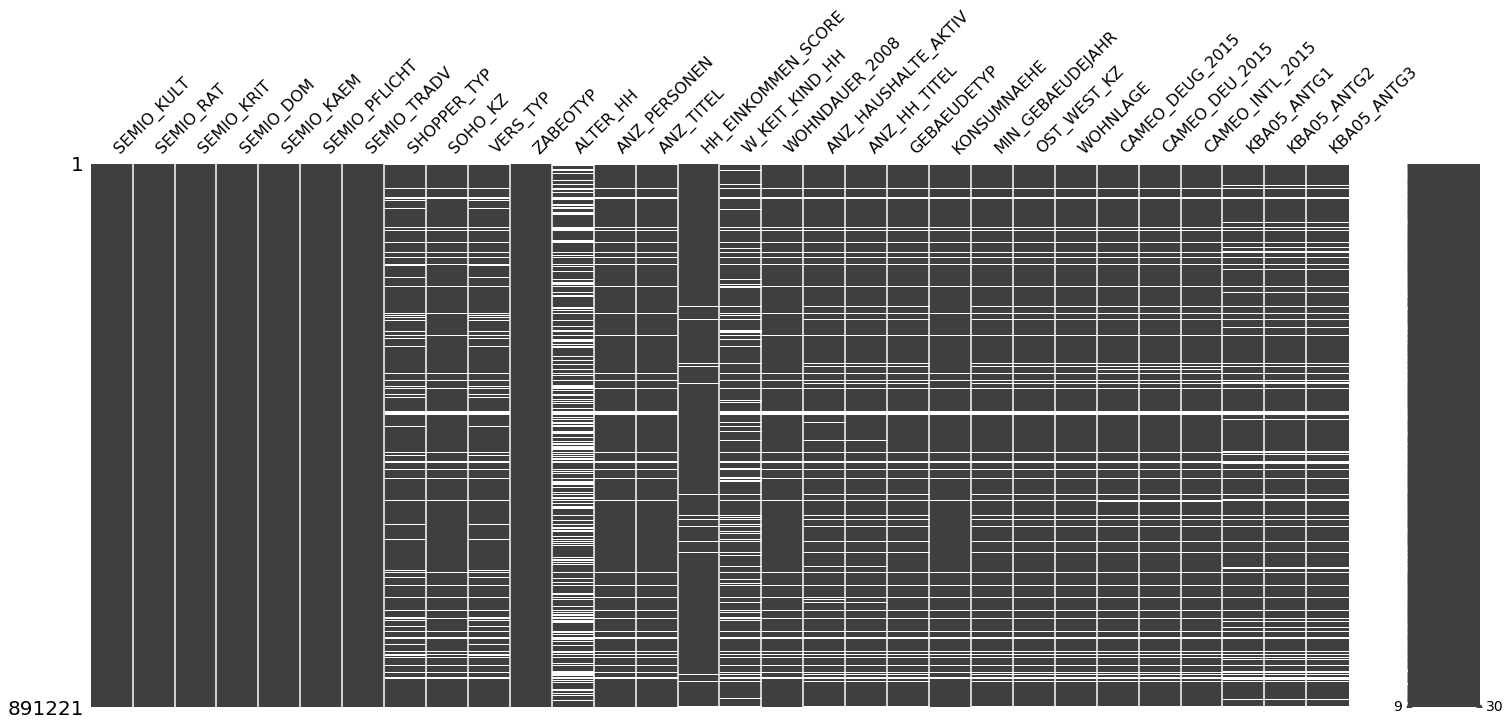

In [19]:
# How many features are there of each data type? Batch 2
msno.matrix(population.iloc[:,30:60]);


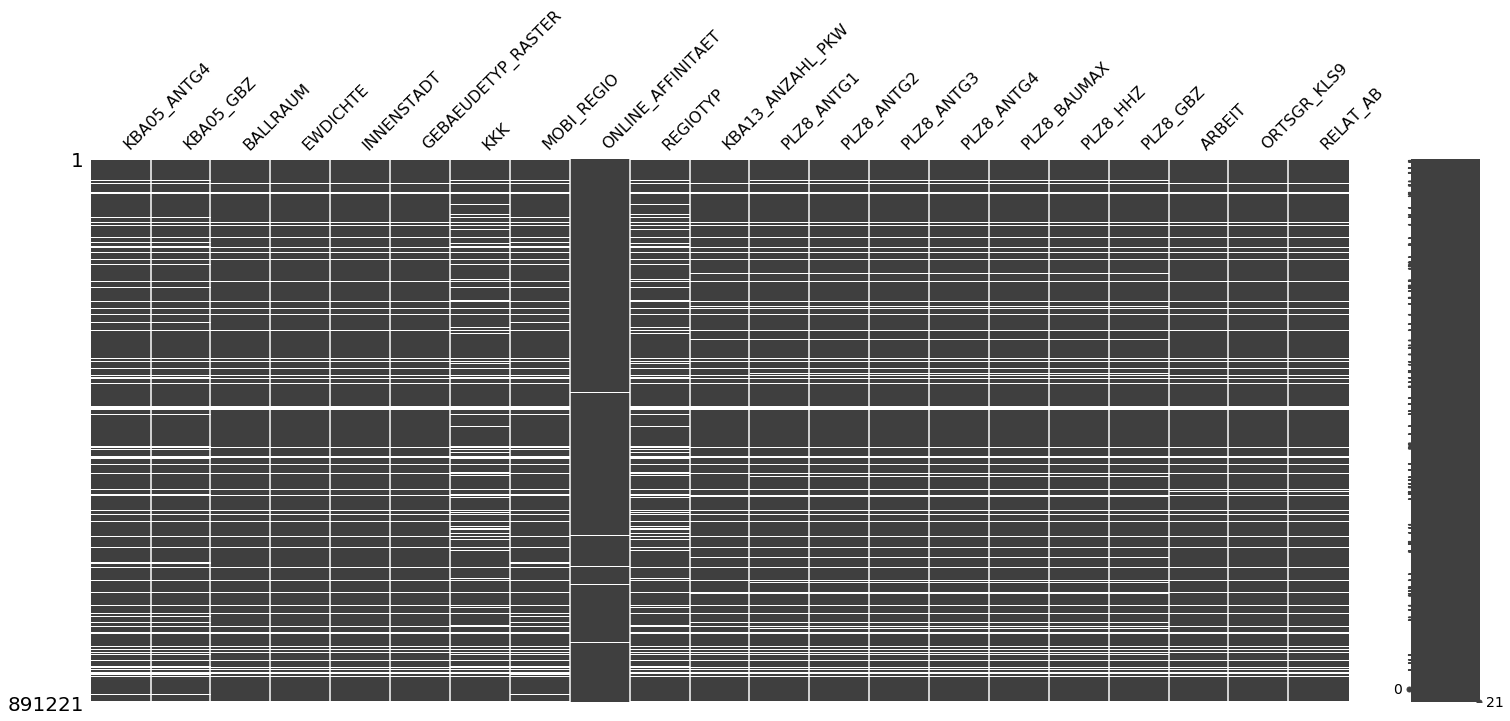

In [20]:
# How many features are there of each data type? Batch 3
msno.matrix(population.iloc[:,60:90]);


In [21]:
# the data is divided into two subsets based on the number of missing values in each row.
subset1 = population.drop(msval_idxlist, axis = 0)
subset2 = population.loc[msval_idxlist, :]
subset1.isna().sum().sum(), subset2.isna().sum().sum()

(1551239, 4186650)

Top columns with missing values (['ALTER_HH', 'KKK', 'REGIOTYP', 'W_KEIT_KIND_HH', 'KBA05_GBZ']) are compared in two subsets of data: 
1 with less than 25 missing values per row
1 with more than 25 missing values per row.


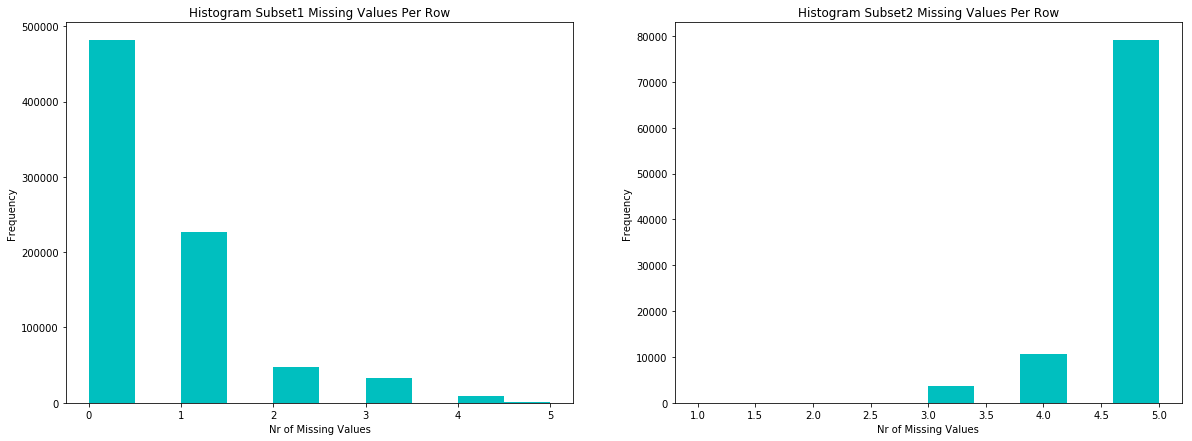

In [22]:
# Compare the distribution of values for five columns where there are no or few missing values, between the two subsets.

topcols_msvals = population.isna().sum().sort_values(ascending=False)[1:6].index
print(f'Top columns with missing values ({list(topcols_msvals)}) are compared in two subsets of data: \n1 with less than {limit} missing values per row\n1 with more than {limit} missing values per row.')

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.hist(subset1[topcols_msvals].isna().sum(axis=1).sort_values(ascending=False), color='c');
plt.title(f'Histogram Subset1 Missing Values Per Row')
plt.xlabel('Nr of Missing Values')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(subset2[topcols_msvals].isna().sum(axis=1).sort_values(ascending=False), color='c');
plt.title('Histogram Subset2 Missing Values Per Row')
plt.xlabel('Nr of Missing Values')
plt.ylabel('Frequency')

plt.show()

In [23]:
# Progress with subset1 and reset index of the dataset
subset1.reset_index(inplace=True, drop=True)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The data missing values have been assessed visually to find distribution patterns over specific columns. From these, the data is divided into two subsets: One with less than 25 missing values and one with more than 25 missing values. The missing values could have been imputed, since there are many missing values per column the end result of an machine learning algorithm would be misleadning if it's based on a high degree of data imputed by a simple imputation method as 'mean' or 'median'. For sufficient accuracy, a more sophisticated method as kNN or similar would be required (which is not prioritized in this project).

  
To show the differences between the two resulting subsets, two histograms were created with each subset and the 5 columns with highest missing values. The two subsets contain mostly different nr of missing values per row, the first with the majority of the rows having close to zero missing values and the second with most of the rows containing 5 missing values. There are still a few rows with similar nr of missing values per row, but for other columns. In my opinion they are very few and can therefore be adjusted by imputation. 

### Step 1.2: Select and Re-Encode Features
- One Hot Encoding
- Feature Selection

**Assumptions (using the feature summary `feat_info`):**
    - For numeric and interval data, these features can be kept without changes.
    - Most of the variables in the dataset are ordinal and treated as being intervals, kept without any changes.
    - For the remaining two variable types: categorical, and 'mixed' special handling are required.

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, the data is encoded to the levels as dummy variables. Depending on the number of categories, following assumtions are being made:
- For binary (two-level) categoricals that take numeric values, are keeped without any changes.
- For one binary variable that takes on non-numeric values, the values are re-encodes as numbers or as dummy variables.
- For multi-level categoricals (three or more values), the values are encoded using multiple dummy variables or dropped.

In [24]:
# How many features are there of each data type?
subset2.dtypes.value_counts()


float64    53
int64      24
object      4
dtype: int64

In [25]:
# Assessment of categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?

# Identify categorical columns
cat_cols = []
cat_cols = list(feat_info.attribute[feat_info.type == 'categorical'].values)

# Merge the two column lists & remove removed columns
for cat_col in cat_cols:
    if cat_col in outlier_column_name:
        cat_cols.remove(cat_col)

# Check unique values in each categorical column
binary_cols = []

for i in range(0, len(cat_cols)):
    #print(i, cat_cols[i])
    #print(subset1[cat_cols[i]].unique())
    
    if subset1[cat_cols[i]].nunique() == 2:
        binary_cols.append(cat_cols[i])
        
binary_cols.remove('OST_WEST_KZ') # Have to encode this column

# Remove binary columns from the fix-list, I will leave them as they are
for i in range(0,len(binary_cols)):
    cat_cols.remove(binary_cols[i])

In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.
# One hot encode OST_WEST_KZ
subset1[['OST_WEST_KZ_O', 'OST_WEST_KZ_W']] = pd.get_dummies(subset1.OST_WEST_KZ)
subset1.drop('OST_WEST_KZ', axis=1, inplace=True)
cat_cols.remove('OST_WEST_KZ')
list(subset1[cat_cols].select_dtypes('object').columns)

['CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

In [27]:
# Drop micro information level data
drop_cols = list(subset1[cat_cols].select_dtypes('object').columns)
subset1.drop(drop_cols, axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features
- For numeric and interval data, these features can be kept without changes.
- The simplifying assumption is made that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).

For the datatypes of 'categorical' and 'mixed':
Binary variables were kept and data on information level microcell_rr4 was droped because it seemed too detailed to be relevant (I would have preffered to talk to any subject matter expert before taking this decision).






#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment. There are two in particular that deserve attention.
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, two new variables are created to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. The two-digit codes are splitted by their 'tens'-place and 'ones'-place digits into two new ordinal variables.
- For other features, please see the discussion. 

In [28]:
# Identify mixed columns
mixed_cols = list(feat_info.attribute[feat_info.type == 'mixed'].values)
mixed_cols

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [29]:
# Feature engineering of "PRAEGENDE_JUGENDJAHRE"

movement = []
decade = []

for val in subset1.PRAEGENDE_JUGENDJAHRE:
    #print(val)
    
    # movement
    if val in [-1, 0]:
        movement.append(np.nan) # Unknown
        
    elif val in [1,3,5,8,10,12,14]:
        movement.append(0) # Mainstream
        
    else:
        movement.append(1) # Avantgarde
    
    # decade
    if val in [-1,0]:
        decade.append(np.nan) # Unknown
        
    elif val in [1,2]:
        decade.append(40)
    elif val in [3,4]:
        decade.append(50)
    elif val in [5,6,7]:
        decade.append(60)
    elif val in [8,9]:
        decade.append(70)
    elif val in [10,11,12,13]:
        decade.append(80)
    else:
        decade.append(90)

# Create 2 new columns and drop the original
subset1['MOVEMENT'] = pd.DataFrame(movement) 
subset1['DECADE'] = pd.DataFrame(decade)
subset1.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)


4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [30]:
# Remove 'XX' to change dtype
for idx, val in enumerate(subset1.CAMEO_INTL_2015):
    #print(idx, val)
    
    if val == 'XX':
        subset1.CAMEO_INTL_2015.iloc[idx] = -1
        
    else:
        pass

# Change dtype to float (because of nan)
subset1.CAMEO_INTL_2015.astype('float')

0         51.0
1         24.0
2         12.0
3         43.0
4         54.0
5         22.0
6         14.0
7         13.0
8         15.0
9         51.0
10        43.0
11        33.0
12        41.0
13        41.0
14        24.0
15        34.0
16        24.0
17        55.0
18        51.0
19        43.0
20        33.0
21         NaN
22        51.0
23        13.0
24        12.0
25        51.0
26        14.0
27        41.0
28        25.0
29        41.0
          ... 
797873    44.0
797874    32.0
797875    43.0
797876    24.0
797877    55.0
797878    23.0
797879    24.0
797880    14.0
797881    51.0
797882    52.0
797883    41.0
797884    41.0
797885    25.0
797886    24.0
797887    34.0
797888    25.0
797889    41.0
797890    14.0
797891    51.0
797892    41.0
797893    51.0
797894    51.0
797895    34.0
797896    23.0
797897    31.0
797898    41.0
797899    51.0
797900    24.0
797901    51.0
797902    43.0
Name: CAMEO_INTL_2015, Length: 797903, dtype: float64

In [31]:
# Feature engineering of "CAMEO_INTL_2015"
wealth = []
life_stage = []

for i in subset1.CAMEO_INTL_2015:
    #print(i)
    
    if pd.isnull(i) == True or i == -1:
        wealth.append(np.nan)
        life_stage.append(np.nan)
        #print(i, 'first')
        
    else:
        #print(i, 'second')
        x = list(int(n) for n in str(i))
        #print(i, x[0], x[1])
        wealth.append(x[0])
        life_stage.append(x[1])

# Create 2 new columns and drop the original
subset1['WEALTH'] = wealth
subset1['LIFE_STAGE'] = life_stage
subset1.drop('CAMEO_INTL_2015', axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features
Of the mixed-type features ('LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX') I decided to split and drop PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 into MOVEMENT, DECADE, WEALTH & LIFE_STAGE. The rest of the mixed-type columns can be kept as they are.

#### Step 1.2.3: Complete Feature Selection

Make sure that the data consists of only:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

In [32]:
# View datatypes
subset1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797903 entries, 0 to 797902
Data columns (total 82 columns):
ALTERSKATEGORIE_GROB     795103 non-null float64
ANREDE_KZ                797903 non-null int64
CJT_GESAMTTYP            793208 non-null float64
FINANZ_MINIMALIST        797903 non-null int64
FINANZ_SPARER            797903 non-null int64
FINANZ_VORSORGER         797903 non-null int64
FINANZ_ANLEGER           797903 non-null int64
FINANZ_UNAUFFAELLIGER    797903 non-null int64
FINANZ_HAUSBAUER         797903 non-null int64
FINANZTYP                797903 non-null int64
GEBURTSJAHR              487114 non-null float64
GFK_URLAUBERTYP          793208 non-null float64
GREEN_AVANTGARDE         797903 non-null int64
HEALTH_TYP               761243 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750710 non-null float64
LP_FAMILIE_FEIN          766547 non-null float64
LP_FAMILIE_GROB          766547 non-null float64
LP_STATUS_FEIN           

In [33]:
# View data
subset1.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,1.0,2,5.0,1,5,2,5,4,5,1,...,4.0,3.0,5.0,4.0,0,1,0,90,5.0,1.0
1,3.0,2,3.0,1,4,1,2,3,5,1,...,4.0,3.0,5.0,2.0,0,1,1,90,2.0,4.0
2,4.0,2,2.0,4,2,5,2,1,2,6,...,4.0,2.0,3.0,3.0,0,1,0,70,1.0,2.0
3,3.0,1,5.0,4,3,4,1,3,2,5,...,3.0,4.0,6.0,5.0,0,1,0,70,4.0,3.0
4,1.0,2,2.0,3,1,5,2,2,5,2,...,5.0,2.0,3.0,3.0,0,1,0,50,5.0,4.0


### Step 1.3: Create a Cleaning Function

For reproductive cleaning, a function is created to be used on the customers demographics data.

In [34]:
def clean_data(df, col_limit=0.5, row_limit=25):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # Create copy to clean on
    data = df.copy()
    #print(f'Nr input data columns: {len(data.columns)}')
    
    # convert missing value codes into NaNs, ...
    # Identify missing or unknown data values and convert them to NaNs.
    for i in range(len(feat_info)):

        missing_or_unknown_data = feat_info.iloc[i]['missing_or_unknown']
        missing_or_unknown_data = missing_or_unknown_data.strip('[]').split(',')
        missing_or_unknown_data = [int(value) if (value!='' and value!='X' and value!='XX') else value for value in missing_or_unknown_data]

        if missing_or_unknown_data != ['']:
            #print(f'Missing or unknown data: {feat_info.iloc[i]["attribute"]} : {missing_or_unknown_data}')
            df = df.replace({feat_info.iloc[i]['attribute']:missing_or_unknown_data}, np.nan)

    # save the new dataframe 
    df.to_csv('customer_data_find_nans.csv')
    
    # finn any other nan with nans
    data.fillna(np.nan, inplace=True)
    
    # remove selected columns and rows, ...
    
    # remove columns with more than col_limit missing data
    #ms_val_cols = (data.isna().sum()/data.shape[0]).sort_values(ascending=False)
    columns_na50 = outlier_column_name #list(ms_val_cols[ms_val_cols.values > col_limit].index)
    data.drop(columns_na50, axis=1, inplace=True)
    print(f'Droped columns: {columns_na50}')
    
    # remove data with row_limit missing columns
    ms_val_rows = data.isna().sum(axis=1).sort_values(ascending=False)
    rows_na25 = list(ms_val_rows[ms_val_rows > row_limit].index)
    subset1 = data.drop(rows_na25, axis = 0)
    
    # select, re-encode, and engineer column values.
    
    # Step 1.2.1 Re-encode Categorical Features
    # One hot encode OST_WEST_KZ
    subset1[['OST_WEST_KZ_O', 'OST_WEST_KZ_W']] = pd.get_dummies(subset1.OST_WEST_KZ)
    subset1.drop('OST_WEST_KZ', axis=1, inplace=True)
    
    # Drop micro information level data
    cat_cols = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    drop_cols = list(subset1[cat_cols].select_dtypes('object').columns)
    subset1.drop(drop_cols, axis=1, inplace=True)
    
    # Step 1.2.2: Engineer Mixed-Type Features
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    movement = []
    decade = []

    for val in subset1.PRAEGENDE_JUGENDJAHRE:
        #print(val)

        # movement
        if val in [-1, 0]:
            movement.append(np.nan) # Unknown

        elif val in [1,3,5,8,10,12,14]:
            movement.append(0) # Mainstream

        else:
            movement.append(1) # Avantgarde

        # decade
        if val in [-1,0]:
            decade.append(np.nan) # Unknown

        elif val in [1,2]:
            decade.append(40)
        elif val in [3,4]:
            decade.append(50)
        elif val in [5,6,7]:
            decade.append(60)
        elif val in [8,9]:
            decade.append(70)
        elif val in [10,11,12,13]:
            decade.append(80)
        else:
            decade.append(90)

    # Create 2 new columns from PRAEGENDE_JUGENDJAHRE
    subset1['MOVEMENT'] = pd.DataFrame(movement) 
    subset1['DECADE'] = pd.DataFrame(decade)
    subset1.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

    # CAMEO_INTL_2015: Remove 'XX' to change dtype
    for idx, val in enumerate(subset1.CAMEO_INTL_2015):
    #print(idx, val)

        if val == 'XX':
            subset1.CAMEO_INTL_2015.iloc[idx] = -1

        else:
            pass

    # Change dtype to float (because of nan)
    subset1.CAMEO_INTL_2015.astype('float')
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    wealth = []
    life_stage = []

    for i in subset1.CAMEO_INTL_2015:
        #print(i)

        if pd.isnull(i) == True or i == -1:
            wealth.append(np.nan)
            life_stage.append(np.nan)
            #print(i, 'first')

        else:
            #print(i, 'second')
            x = list(int(n) for n in str(i))
            #print(i, x[0], x[1])
            wealth.append(x[0])
            life_stage.append(x[1])

    # Create new columns
    subset1['WEALTH'] = wealth
    subset1['LIFE_STAGE'] = life_stage
    subset1.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return subset1
    

In [35]:
# perform the cleaning in one step
clean_df = clean_data(azdias)
clean_df.head()

Droped columns: Index(['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], dtype='object')


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
1,1.0,2,5.0,1,5,2,5,4,5,1,...,4.0,3.0,5.0,4.0,0,1,1.0,90.0,5.0,1.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,4.0,3.0,5.0,2.0,0,1,0.0,70.0,2.0,4.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,4.0,2.0,3.0,3.0,0,1,0.0,70.0,1.0,2.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,3.0,4.0,6.0,5.0,0,1,0.0,50.0,4.0,3.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,5.0,2.0,3.0,3.0,0,1,0.0,80.0,5.0,4.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Imputation of missing values and feature scaling are performed so that the principal component vectors are not influenced by the natural differences in scale for features.

In [36]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797903 entries, 1 to 891220
Data columns (total 82 columns):
ALTERSKATEGORIE_GROB     795103 non-null float64
ANREDE_KZ                797903 non-null int64
CJT_GESAMTTYP            793208 non-null float64
FINANZ_MINIMALIST        797903 non-null int64
FINANZ_SPARER            797903 non-null int64
FINANZ_VORSORGER         797903 non-null int64
FINANZ_ANLEGER           797903 non-null int64
FINANZ_UNAUFFAELLIGER    797903 non-null int64
FINANZ_HAUSBAUER         797903 non-null int64
FINANZTYP                797903 non-null int64
GEBURTSJAHR              487114 non-null float64
GFK_URLAUBERTYP          793208 non-null float64
GREEN_AVANTGARDE         797903 non-null int64
HEALTH_TYP               761243 non-null float64
LP_LEBENSPHASE_FEIN      747828 non-null float64
LP_LEBENSPHASE_GROB      750710 non-null float64
LP_FAMILIE_FEIN          766547 non-null float64
LP_FAMILIE_GROB          766547 non-null float64
LP_STATUS_FEIN           

In [37]:
def feature_scaling(clean_df):
    '''
    Perform impuatation and feature scaling (standard scaler) on the dataframe.
    INPUT: The dataframe to be scaled
    OUTPUT: The scaled dataframe, the scaler object, the imputation object
    '''
    
    # Impute nans
    fill_nan_obj = Imputer(strategy='median')
    fill_nan_imp = fill_nan_obj.fit_transform(clean_df)
    imputed_df = pd.DataFrame(fill_nan_imp)
    imputed_df.columns = clean_df.columns
    imputed_df.index = clean_df.index

    # Apply feature scaling to the general population demographics data.
    scaler = StandardScaler()
    scaler_fit = scaler.fit_transform(imputed_df)
    scaled_df = pd.DataFrame(scaler_fit)
    scaled_df.columns = imputed_df.columns
    scaled_df.index = imputed_df.index
    
    return scaled_df, scaler, fill_nan_obj


In [38]:
# feature scaling
scaled_df, scaler, fill_nan_obj = feature_scaling(clean_df)

In [39]:
# verification imputation
scaled_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
1,-1.766592,0.957947,0.974417,-1.494622,1.537995,-1.040674,1.466085,0.958903,1.339194,-1.342195,...,0.574191,-0.166448,-0.127087,0.684844,-0.517446,0.517446,1.835961,1.105160,1.186184,-1.266935
2,0.200536,0.957947,-0.329776,-1.494622,0.864629,-1.766937,-0.570939,0.244331,1.339194,-1.342195,...,0.574191,-0.166448,-0.127087,-0.789053,-0.517446,0.517446,-0.544674,-0.325146,-0.868186,0.761262
3,1.184100,0.957947,-0.981873,0.683154,-0.482103,1.138113,-0.570939,-1.184813,-0.791410,1.056246,...,0.574191,-1.169974,-0.997612,-0.052104,-0.517446,0.517446,-0.544674,-0.325146,-1.552975,-0.590869
4,0.200536,-1.043899,0.974417,0.683154,0.191263,0.411851,-1.249947,0.244331,-0.791410,0.576558,...,-0.337230,0.837077,0.308175,1.421793,-0.517446,0.517446,-0.544674,-1.755452,0.501394,0.085196
5,-1.766592,0.957947,-0.981873,-0.042771,-1.155469,1.138113,-0.570939,-0.470241,1.339194,-0.862507,...,1.485612,-1.169974,-0.997612,-0.052104,-0.517446,0.517446,-0.544674,0.390007,1.186184,0.761262


### Discussion 2.1: Apply Feature Scaling
Since we removed the columns and rows with large missing values, the missing data here is minor. Removal of the full columns or rows would make us loose a lots of information. So, I have decided to impute the values to the mean. In a professional setting, Id rather discuss the characteristics of each column but here I choose a median imputation. 

I chosed to standardize the dataset, to mean=0 and standard deviation=1.

### Step 2.2: Perform Dimensionality Reduction

After scaling, dimensionality reduction with PCA is applied.

In [40]:
# Apply PCA to the data.

def do_pca(data, n_components=None):
    
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
        
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    
    return pca, X_pca


In [41]:
def pareto_plot(pca, limit = 1):
    
    '''
    Creates a pareto/scree plot associated with the principal components
    INPUT: pca - the result of instantian of PCA in scikit learn
           limit - variance to be explained by the principal components
    OUTPUT: nr_comps - nr of components which cover the wanted variance
    '''
    
    nr_components = len(pca.explained_variance_ratio_) # Nr of principal components
    comp_array = np.arange(nr_components) # Array of the range of principal component indecies
    vals = pca.explained_variance_ratio_ # Explained variance ratio for each principal component
    cumvals = np.cumsum(vals) # Ackumulated sum
    
    # Reduction of principal components by limit on explained variance
    new_cumvals = cumvals[cumvals < limit]
    nr_comps = len(new_cumvals)
    lencomp_arr = np.arange(nr_comps)
    new_vals = vals[0:nr_comps]

    plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    plt.bar(lencomp_arr, new_vals, color='c');
    plt.plot(lencomp_arr, new_cumvals, color='c');
    
    #for i in range(nr_components):
        #ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (comp_array[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    plt.xlabel("Principal Component");
    plt.ylabel("Variance Explained (%)");
    plt.title('Explained Variance Per Principal Component');
    
    return nr_comps

In [42]:
# pca analysis
pca, X_pca = do_pca(scaled_df.values)

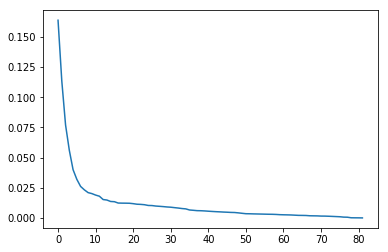

In [43]:
# Investigate the variance accounted for by each principal component.
plt.plot(pca.explained_variance_ratio_);


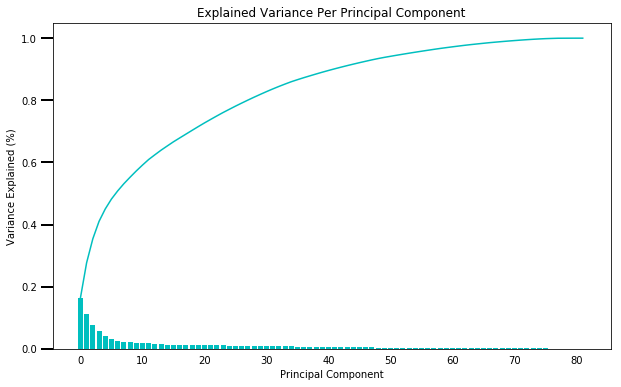

In [44]:
pareto_plot(pca);

The number of recommended principal components are 28


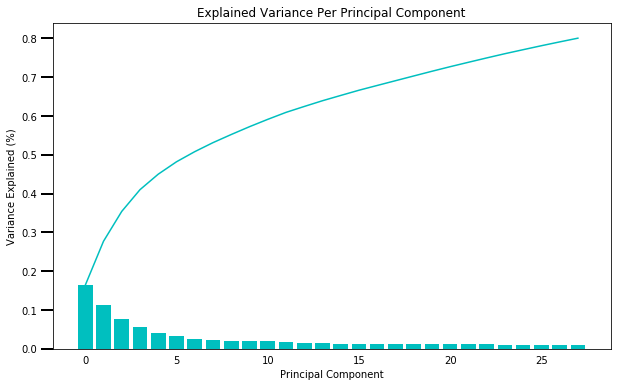

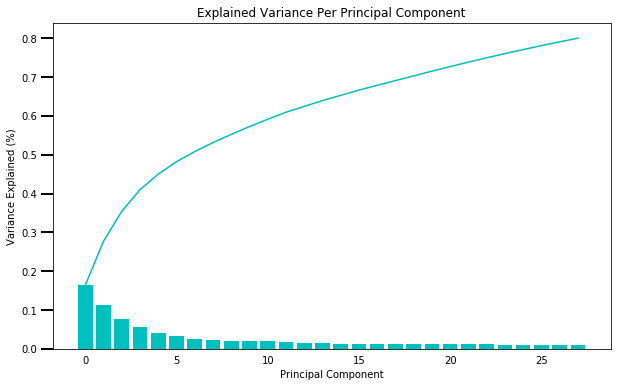

In [45]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_limit = 0.805
nr_pc = pareto_plot(pca, pca_limit)
print(f'The number of recommended principal components are {nr_pc}')
pca_new, X_pca_new = do_pca(scaled_df.values, nr_pc);
pareto_plot(pca_new);

### Discussion 2.2: Perform Dimensionality Reduction
According to the pareto principle: "For many outcomes, roughly 80% of consequences come from 20% of the causes". The PCA analysis shows that 29 principal components account for 80 % of the variance in the data making a dataset variable reduction from 85 variables to 29 principal components.

### Step 2.3: Interpret Principal Components

The weight of each variable on the first few principal components are assessed to see if they can be interpreted.

- Feature investigation, each weight is mapped to their corresponding feature name, then sorted according to weight. The most interesting features for each principal component, are those with highest absolute weight.
- Feature interpretation, the first three principal components are interpretated in this substep.

_A reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other._

In [46]:
def see_component(pca_obj, df_columns, component):
    
    '''
    See the contribution of each variable to one principal component
    INPUT: pca - the pca object
           df_columns - the original df from which you take the column namnes
           component - The name/index of the component of interest
    OUTPUT: The columns namnes and a sorted list of each column contribution to the principal component       
            '''
    
    components = pd.DataFrame(pca_obj.components_) # To view the PCA components generated
    components.columns = df_columns.columns
    components.index = range(1,len(components)+1)
    
    return components.iloc[component,:].sort_values(ascending=False)


In [47]:
# Weights of the first principal component
component_1 = see_component(pca_new, scaled_df, 1)
component_1.abs().sort_values(ascending=False).head(), component_1.tail()

(ALTERSKATEGORIE_GROB     0.262057
 SEMIO_REL                0.250714
 FINANZ_SPARER            0.249063
 FINANZ_VORSORGER         0.237007
 FINANZ_UNAUFFAELLIGER    0.231612
 Name: 2, dtype: float64, SEMIO_TRADV             -0.229638
 SEMIO_PFLICHT           -0.231284
 FINANZ_UNAUFFAELLIGER   -0.231612
 FINANZ_SPARER           -0.249063
 SEMIO_REL               -0.250714
 Name: 2, dtype: float64)

In [48]:
# Weights of the second principal component
component_2 = see_component(pca_new, scaled_df, 2)
component_2.abs().sort_values(ascending=False).head(), component_2.tail()


(ANREDE_KZ     0.364834
 SEMIO_VERT    0.337985
 SEMIO_KAEM    0.336303
 SEMIO_DOM     0.310453
 SEMIO_KRIT    0.273488
 Name: 3, dtype: float64, SEMIO_RAT    -0.195274
 SEMIO_KRIT   -0.273488
 SEMIO_DOM    -0.310453
 SEMIO_KAEM   -0.336303
 ANREDE_KZ    -0.364834
 Name: 3, dtype: float64)

In [49]:
# Weights of the third principal component
component_3 = see_component(pca_new, scaled_df, 3)
component_3.head(), component_3.tail()


(LP_FAMILIE_GROB        0.361321
 LP_FAMILIE_FEIN        0.359479
 LP_LEBENSPHASE_GROB    0.350883
 LP_LEBENSPHASE_FEIN    0.340263
 ANZ_PERSONEN           0.309626
 Name: 4, dtype: float64, PLZ8_ANTG1       -0.116085
 WOHNLAGE         -0.129576
 BALLRAUM         -0.138010
 INNENSTADT       -0.151027
 W_KEIT_KIND_HH   -0.212759
 Name: 4, dtype: float64)

### Discussion 2.3: Interpret Principal Components
- For the first principal component; ALTERSKATEGORIE_GROB (+), SEMIO_REL (-), FINANZ_SPARER (-) contributes the most to the principal component and the variance it can explain in the data.
- For the second principal component; ANREDE_KZ (-), SEMIO_VERT (+), SEMIO_KAEM (-) contributes the most to the principal component and the variance it can explain in the data.
- For the third principal component; LP_FAMILIE_GROB (+), LP_FAMILIE_FEIN (+), LP_LEBENSPHASE_GROB (+) contributes the most to the principal component and the variance it can explain in the data.

_The sign of the weight for each original component show the direction of impact on the PC. The total the impact from the original component on the principal component remains the same as the absolute value regardless of direction._

## Step 3: Clustering

### Step 3.1: Clustering of the General Population

The _general population_ demographics data is assessed, cleaned, scaled and transformed. Now, it's time to see how the data clusters in the principal components space. For this, k-means clustering is applied to the dataset.
- Find reasonable nr of clusters with a scree plot
- Use k-means for the chosen nr of clusters

In [50]:
scaled_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
1,-1.766592,0.957947,0.974417,-1.494622,1.537995,-1.040674,1.466085,0.958903,1.339194,-1.342195,...,0.574191,-0.166448,-0.127087,0.684844,-0.517446,0.517446,1.835961,1.105160,1.186184,-1.266935
2,0.200536,0.957947,-0.329776,-1.494622,0.864629,-1.766937,-0.570939,0.244331,1.339194,-1.342195,...,0.574191,-0.166448,-0.127087,-0.789053,-0.517446,0.517446,-0.544674,-0.325146,-0.868186,0.761262
3,1.184100,0.957947,-0.981873,0.683154,-0.482103,1.138113,-0.570939,-1.184813,-0.791410,1.056246,...,0.574191,-1.169974,-0.997612,-0.052104,-0.517446,0.517446,-0.544674,-0.325146,-1.552975,-0.590869
4,0.200536,-1.043899,0.974417,0.683154,0.191263,0.411851,-1.249947,0.244331,-0.791410,0.576558,...,-0.337230,0.837077,0.308175,1.421793,-0.517446,0.517446,-0.544674,-1.755452,0.501394,0.085196
5,-1.766592,0.957947,-0.981873,-0.042771,-1.155469,1.138113,-0.570939,-0.470241,1.339194,-0.862507,...,1.485612,-1.169974,-0.997612,-0.052104,-0.517446,0.517446,-0.544674,0.390007,1.186184,0.761262


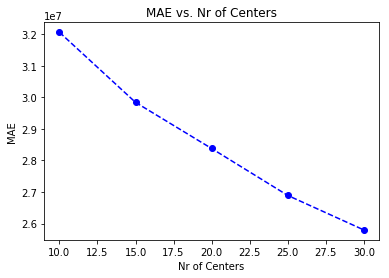

In [51]:
# scree or elbow plot to determine the nr clusters

with active_session():

    scores = []
    inertias = []
    nr_centers = list(range(10,35,5))

    for center in nr_centers:

        # k-means clustering
        kmeans = KMeans(center)
        model = kmeans.fit(X_pca_new)

        # the average within-cluster distances
        score = np.abs(model.score(X_pca_new)) # abs score = intertia
        inertia = np.abs(model.inertia_) # measuring the sum of the squared distances to the nearest cluster center aka inertia.

        # save to score-list
        scores.append(score)
        inertias.append(inertia)

    # Plot the change in within-cluster distance across number of clusters.
    plt.plot(nr_centers, scores, linestyle='--', marker='o', color='b');
    plt.xlabel('Nr of Centers');
    plt.ylabel('MAE');
    plt.title('MAE vs. Nr of Centers'); # 25 centers seems good
    

In [52]:
# obtain cluster predictions
nr_center = 25

# refit k-means clustering on the data
kmeans = KMeans(nr_center, random_state=2)
model = kmeans.fit_predict(X_pca_new)

# the average within-cluster distances
score = np.abs(kmeans.score(X_pca_new)) # the sum of distances between data samples and their associated cluster centers.
inertia = kmeans.inertia_ # Mean distance between the observation and all other data points in the same cluster. This distance can also be called a mean intra-cluster distance.
print(score, inertia)


26882307.2047 26882307.2047


In [53]:
# create result-df
gen_pop = pd.DataFrame(X_pca_new)
gen_pop.columns = range(1,29,1)
gen_pop['cluster_label'] = model
gen_pop.head()
gen_pop.to_csv('clean_pcacluster_popdata.csv')

### Discussion 3.1: Apply Clustering to General Population

The features of the general population are concentrated to 29 principal components and they are in turn divided into 25 clusters.

### Step 3.2: Apply All Steps to the Customer Data

For the general population, all processing is completed. Now it is time for equal processing of the customer dataset before comparison of the datasets.


In [54]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [55]:
# Preprocessing, feature transformation and clustering from the general
# demographics are applied onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# clean
clean_custs = clean_data(customers)

# impute to fill nan
fill_nan = fill_nan_obj.fit_transform(clean_custs)
imputed_cust = pd.DataFrame(fill_nan)
imputed_cust.columns = clean_custs.columns
imputed_cust.index = clean_custs.index

# feature scaling - only transform
scaled_custs = scaler.transform(imputed_cust)

# PCA - only predict
cust_pcapreds = pca_new.transform(scaled_custs)

# clusters - only predict
cust_clustpreds = kmeans.predict(cust_pcapreds)

# customer poulation-df
cust_pop = pd.DataFrame(scaled_custs)
cust_pop.columns = clean_custs.columns
cust_pop['cluster_label'] = cust_clustpreds

# save data
cust_pop.to_csv('clean_pcacluster_custdata.csv')

Droped columns: Index(['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX'], dtype='object')


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Step 3.3: Compare Customer Data to Demographics Data

So far we have maps demographic cluster of the general population in Germany and the customers of a mail-order sales company. Now it is time to compare these clusters to draw conclusions about the companys most and least representative customer group.

- Proportion of data points in each cluster for both populations & comparison of proportions
- Find over and under represented groups
- Reintroduce original features from the principal components of over and under represented groups

In [56]:
# Use of saved data
#gen_pop = pd.read_csv('clean_pcacluster_popdata.csv')
#cust_pop = pd.read_csv('clean_pcacluster_custdata.csv')

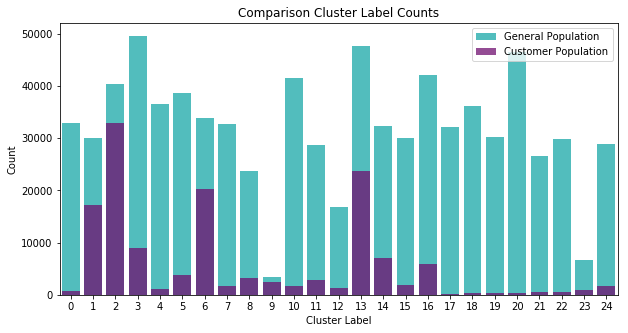

In [57]:
# Comparison of the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population
plt.figure(figsize=(10,5))
sb.countplot(gen_pop.cluster_label, color='c', alpha=0.75);
plt.title('Comparison Cluster Label Counts');
sb.countplot(cust_pop.cluster_label, color='purple', alpha=0.75);
plt.legend(['General Population', 'Customer Population'])
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.show()

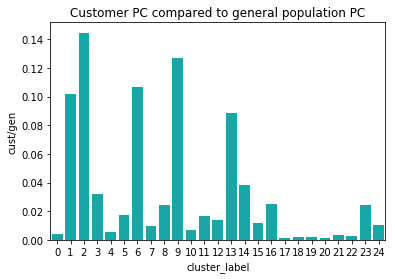

In [58]:
# Finding over and under representive groups
count_labels = pd.DataFrame(gen_pop.groupby(['cluster_label'])['cluster_label'].count())
count_labels.columns = ['genpop_labels']
count_labels['custpop_labels'] = cust_pop.groupby(['cluster_label'])['cluster_label'].count()

count_labels['custpop_part'] = count_labels.custpop_labels/len(gen_pop)
count_labels['genpop_part'] = count_labels.genpop_labels/len(cust_pop)

count_labels['cust/gen'] =  count_labels.custpop_part / count_labels.genpop_part
count_labels.sort_values(by = 'cust/gen', ascending=False, inplace=True)

# Plot
sb.barplot(x = count_labels.index, y = count_labels['cust/gen'], color='c');
plt.title('Customer PC compared to general population PC');



In [59]:
# re-introduce the original features
centeroids = kmeans.cluster_centers_
transformed_pcas = pca_new.inverse_transform(centeroids) # get the data back from pca transform
customer_groups = scaler.inverse_transform(transformed_pcas) # get the data back from scaler transform


In [60]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population? Ex. PC nr 5
resulting_groups = pd.DataFrame(customer_groups, columns=clean_custs.columns)
resulting_groups.iloc[12,:]

ALTERSKATEGORIE_GROB        2.807565
ANREDE_KZ                   1.537883
CJT_GESAMTTYP               3.840214
FINANZ_MINIMALIST           3.920277
FINANZ_SPARER               2.832967
FINANZ_VORSORGER            2.915454
FINANZ_ANLEGER              2.982385
FINANZ_UNAUFFAELLIGER       3.911167
FINANZ_HAUSBAUER            0.810729
FINANZTYP                   2.721036
GEBURTSJAHR              1969.960060
GFK_URLAUBERTYP             7.102516
GREEN_AVANTGARDE            0.239539
HEALTH_TYP                  1.950632
LP_LEBENSPHASE_FEIN        18.740745
LP_LEBENSPHASE_GROB         5.413201
LP_FAMILIE_FEIN             3.632511
LP_FAMILIE_GROB             2.357153
LP_STATUS_FEIN              8.280209
LP_STATUS_GROB              3.921010
NATIONALITAET_KZ            1.159013
RETOURTYP_BK_S              3.828222
SEMIO_SOZ                   2.793927
SEMIO_FAM                   4.125492
SEMIO_REL                   3.706277
SEMIO_MAT                   5.028926
SEMIO_VERT                  4.998986
S

In [61]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population? Ex. PC nr 4
resulting_groups.iloc[1,:]


ALTERSKATEGORIE_GROB        3.846354
ANREDE_KZ                   1.039191
CJT_GESAMTTYP               2.639075
FINANZ_MINIMALIST           3.467193
FINANZ_SPARER               1.338437
FINANZ_VORSORGER            4.750501
FINANZ_ANLEGER              1.225232
FINANZ_UNAUFFAELLIGER       1.368492
FINANZ_HAUSBAUER            4.069576
FINANZTYP                   4.797022
GEBURTSJAHR              1955.151595
GFK_URLAUBERTYP             6.913447
GREEN_AVANTGARDE            0.072822
HEALTH_TYP                  1.649637
LP_LEBENSPHASE_FEIN        10.402866
LP_LEBENSPHASE_GROB         3.023910
LP_FAMILIE_FEIN             1.715075
LP_FAMILIE_GROB             1.409117
LP_STATUS_FEIN              2.696007
LP_STATUS_GROB              1.690205
NATIONALITAET_KZ            1.029119
RETOURTYP_BK_S              4.568602
SEMIO_SOZ                   5.293246
SEMIO_FAM                   4.951921
SEMIO_REL                   3.289105
SEMIO_MAT                   4.199367
SEMIO_VERT                  6.291638
S

In [62]:
# save results
resulting_groups.to_csv('resulting_customer_clusters.csv')

### Discussion 3.3: Compare Customer Data to Demographics Data
**What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?**
Cluster 12 contains people that is overrepresented in the customer data, compared to the general population. The overrepresented customer profile seems to be a prepared female of around 60 years old living in a less affluent household and with school age kids, who is an advertising interested store-shopper other features.

_Overrepresented-Customer Data_  
ALTERSKATEGORIE_GROB        3.866646 (around 60 years old)  
ANREDE_KZ                   1.941378 (female)  
CJT_GESAMTTYP               2.494997 (advertisinginterested Store-shopper)  
...  
FINANZTYP                   3.793298 (be prepared (VORSORGER)  
...  
WEALTH                      3.840694 (Less Affluent Households)  
LIFE_STAGE                  3.024168 (Families With School Age Children)  

**What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?**
Cluster 0 contains people that is underrepresented in the customer data, compared to the general population. The underrepresented customer profile seems to be a money saving/house buying male of around 30 years old living in apre-family couples or in couple with young children in a less affluent to poorer household, who is an advertising interested online-shopper among other features.

_Underrepresented-Customer Data_  
ALTERSKATEGORIE_GROB        1.763746 (about 30 years old)  
ANREDE_KZ                   0.940167 (male)  
CJT_GESAMTTYP               3.847014 (advertising interested Online-shopper)  
...  
FINANZTYP                   2.776954 (money-saver (SPARER)/home ownership (HAUSBAUER))  
...  
WEALTH                      4.505215 (Less Affluent Households/Poorer Households)  
LIFE_STAGE                  1.844725 (Pre-Family Couples & Singles/Young Couples With Children)